# Scale-Dependent Modification of Large-Scale Power Spectrum Multipoles

Initiate notebook.

In [1]:
import os
from collections import OrderedDict
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from nbodykit.lab import cosmology
from scipy.integrate import quad
from scipy.misc import derivative

harmony = matplotlib.rc_params_from_file(
    "../config/horizon.mplstyle",
    use_default_template=False
)


We will use *Planck*15 as the fiducial cosmology.

In [2]:
FIDUCIAL_COSMOLOGY = cosmology.Planck15
r""":class:`nbodykit.cosmology.cosmology.Cosmology`: Default *Planck*15
cosmology.

"""

':class:`nbodykit.cosmology.cosmology.Cosmology`: Default *Planck*15\ncosmology.\n\n'

## Base cosmological model

Define the scale-dependence modification function
    $$ A(k, z) = 3 \left(\frac{H_0}{\mathrm{c}}\right)^2 \frac{\delta_\mathrm{c} \Omega_\mathrm{m,0}}{T(k, z)} $$
so that linear bias is modified in the presence of local primordial non-Gaussianity by $\Delta b(k, z) = f_\mathrm{NL} [b_1(z) - 1] {A(k, z)}/{k^2}$.

In [3]:
def scale_dependence_modification(redshift, cosmo=FIDUCIAL_COSMOLOGY):
    """Return the scale-dependence modification due to local primordial
    non-Gaussianity as a function of redshift.

    Parameters
    ----------
    redshift : float
        Redshift.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).

    Returns
    -------
    callable
        Scale-dependence modification as a function of wavenumber
        (in h/Mpc).
        
    """
    SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY = 1.686
    SPEED_OF_LIGHT_IN_KM_PER_S = 2998792.

    numerical_constants = 3 * (100*cosmo.h / SPEED_OF_LIGHT_IN_KM_PER_S)**2 \
        * SPHERICAL_COLLAPSE_CRITICAL_OVERDENSITY * cosmo.Omega0_m
    transfer_function = cosmology.power.transfers.CLASS(cosmo, redshift)

    return lambda k: numerical_constants / transfer_function(k)

Define the general relativistic corrections as a function of redshift
    $$ g(z) = \frac{\dot{\mathcal{H}}}{\mathcal{H}} + \mathcal{H} \left(\frac{2 - 5s}{\mathcal{H} \chi} + 5s - f_\mathrm{ev} \right) $$
with evolution bias $f_\mathrm{ev}(z)$ and magnification bias $s(z)$, so that the Fourier-space 2-point correlator is modified by $\Delta \left\langle \left\vert\delta(z, \mathbf{k})\right\vert^2 \right\rangle = g(z)^2 f(z)^2 (\mu^2/k^2) P_\mathrm{m}(k, z)$.
    
We can rearrange this as the sum of three terms
    $$ g(z) = \underbrace{\frac{2}{\chi} + \mathcal{H} \left[1 - \frac{3}{2} \Omega_\mathrm{m,0} (1 + z)^3\right]}_{\textrm{geometric}} \phantom{+} \underbrace{- \mathcal{H} f_\mathrm{ev}(z)}_{\textrm{evolution}} + \underbrace{5s(z)\left(\mathcal{H} - \frac{1}{\chi}\right)}_{\text{Doppler lensing}} \,. $$

In [4]:
def general_relativistic_corrections(cosmo=FIDUCIAL_COSMOLOGY,
                                     geometric_bias=True,
                                     evolution_bias=None, 
                                     magnification_bias=None):
    """Return the general relativistic corrections as a function of 
    redshift.

    Parameters
    ----------
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
    geometric_bias : bool, optional
        If `True` (default), include geometric bias.
    evolution_bias, magnification_bias : callable or None, optional
        Evolution bias or magnification bias as a function of redshift
        (default is `None`).
        
    Returns
    -------
    callable
        General relativistic correction as a function of redshift.

    """
    background =  cosmology.background.MatterDominated(cosmo.Omega0_m)
    chi = lambda z: cosmo.comoving_distance(z)
    
    H_0 = 100 * cosmo.h
    a = lambda z: (1 + z)**(-1)
    
    H_conformal = lambda z: background.E(a(z)) * a(z) * H_0
    
    if geometric_bias:
        geometric_term = lambda z: 0
    else:
        geometric_term = lambda z: \
            2 / chi(z) + H_conformal(z) * (
                1 - 3/2 * cosmo.Omega0_m / a(z)**3
            ) / H_conformal(z)
    
    if evolution_bias is None:
        evolution_term = lambda z: 0.
    else:
        evolution_term = lambda z: - evolution_bias(z) # * H_conformal(z) 
        
    if magnification_bias is None:
        lensing_term = lambda z: 0.
    else:
        lensing_term = lambda z: \
            5 * magnification_bias(z) * (1 - 1/(H_conformal(z) * chi(z))) # * H_conformal(z) 
    
    return lambda z: geometric_term(z) + evolution_term(z) + lensing_term(z)

## Luminosty function modeller

Generate parametric models for the luminosity function and perform related computations.

In [5]:
class LuminosityFunctionModeller:
    """Luminosity function modeller predicting the comoving number density
    and related quantities.
    
    Parameters
    ----------
    luminosity_model : callable
        Luminosity function parametric model with magnitude, redshift and
        additional arguments (in that order).
    magnitude_limit : float
        Limiting magnitude.
    **model_parameters
        Keyword arguments to be passed to the specified parametric model.
        
    Attributes
    ----------
    luminosity_function : callable
        Luminosity function of magnitude and redshift (in that order) only.
    magnitude_limit : float
        Limiting magnitude.
    model_parameters : dict
        Model parameters.
    
    """
    
    def __init__(self, luminosity_model, magnitude_limit, 
                 **model_parameters):
            
        self.luminosity_function = lambda m, z: \
            luminosity_model(m, z, **model_parameters)
        self.magnitude_limit = magnitude_limit
        self.model_parameters = model_parameters
            
        self._comoving_number_density = None
        self._evolution_bias = None
        self._magnification_bias = None
        
    @classmethod
    def from_parameters_file(cls, luminosity_model, magnitude_limit, 
                             file_path):
        """Instantiate a modeller by reading parameter values from a file.
        
        Parameters
        ----------
        luminosity_model : callable
            Parametric luminosity function model with magnitude and
            redshift arguments and additional arguments (in that order).
        magnitude_limit : float
            Limiting magnitude.
        file_path : str
            Path of the model parameter file.
                
        """
        with open(file_path, 'r') as pfile:
            parameters = tuple(map(
                lambda var_name: var_name.strip(" "), 
                pfile.readline().strip("#").strip("\n").split(",")
            ))
            estimates = tuple(map(
                lambda value: float(value), 
                pfile.readline().split(",")
            ))
            
        return cls(
            luminosity_model, magnitude_limit, 
            **dict(zip(parameters, estimates))
        )
    
    @property
    def comoving_number_density(self):
        """Comoving number density as a function of redshift.
        
        Returns
        -------
        callable
        
        """
        if callable(self._comoving_number_density):
            return self._comoving_number_density
        
        self._comoving_number_density = lambda z: quad(
            self.luminosity_function,
            -40.,  # HINT: Instead of ``-inf`` for numerical stability.
            self.magnitude_limit,
            args=(z,)
        )[0]
        
        return self._comoving_number_density
    
    @property
    def evolution_bias(self):
        """Evolution bias as a function of redshift.
        
        Returns
        -------
        callable
        
        """
        if callable(self._evolution_bias):
            return self._evolution_bias
        
        ln_comoving_number_density = lambda z: \
            np.log(self.comoving_number_density(z))
        
        self._evolution_bias = lambda z: \
            3 - (1 + z) * derivative(ln_comoving_number_density, z, dx=1e-2)
        
        return self._evolution_bias
    
    @property
    def magnification_bias(self):
        """Magnification bias as a function of redshift.
        
        Returns
        -------
        callable
        
        """        
        if callable(self._magnification_bias):
            return self._magnification_bias
        
        lg_luminosity_function = lambda m, z: \
            np.log10(self.luminosity_function(m, z))
        
        self._magnification_bias = lambda z: \
            self.luminosity_function(self.magnitude_limit, z) \
            / (np.log(10) * self.comoving_number_density(z))
        
        return self._magnification_bias

Quasar luminosity function in the pure luminosity evolution model.

In [6]:
def quasar_luminosity_function_in_PLE_model(magnitude, redshift, 
                                            redshift_pivot=2.2, 
                                            **model_parameters_PLE):
    """Evaluate the pure luminosity evolution (PLE) model for the quasar
    luminosity function at the given absolute magnitude and redshift.
    
    Notes
    -----
    Magnitude is absolute and measured in :math:`g`-band normalised to
    the value at redshift 2.
    
    Parameters
    ----------
    magnitude : float
        Quasar magnitude.
    redshift : float
        Quasar redshift.
    redshift_pivot : float, optional
        Pivot redshift.
    **model_parameters_PLE
        PLE model parameters.
    
    Returns
    -------
    comoving_density : float :class:`numpy.ndarray`
        Predicted qausar comoving number density per unit magnitude.
        
    """    
    # Re-definitions.
    M_g, z, z_p = magnitude, redshift, redshift_pivot
    
    # Determine the redshift end.
    if z <= z_p:
        subscript = '\\textrm{{{}}}'.format('l')
    else:
        subscript = '\\textrm{{{}}}'.format('h') 
    
    # Set parameters.
    Phi_star = 10**model_parameters_PLE['\\log\\Phi^\\ast']
    M_g_star_p = model_parameters_PLE['M^\\ast_g(z_\\textrm{pivot})']
    
    alpha = model_parameters_PLE['\\alpha_{}'.format(subscript)]
    beta = model_parameters_PLE['\\beta_{}'.format(subscript)]
    k_1 = model_parameters_PLE['k_{{1{}}}'.format(subscript)]
    k_2 = model_parameters_PLE['k_{{2{}}}'.format(subscript)]
    
    # Evaluate the model prediction.
    exponent_magnitude_factor = M_g \
        - (M_g_star_p - 2.5*(k_1 * (z - z_p) + k_2 * (z - z_p)**2))
    
    faint_power_law = 10 ** (0.4*(alpha + 1) * exponent_magnitude_factor)
    bright_power_law = 10 ** (0.4*(beta + 1) * exponent_magnitude_factor)
    
    comoving_density = Phi_star / (faint_power_law + bright_power_law)
    
    return comoving_density

## Power spectrum modification

Power spectrum multipole modification as a function of scale and redshift.

In [7]:
def general_relativistic_modification(wavenumber, redshift, multipole,
                                      cosmo=FIDUCIAL_COSMOLOGY,
                                      geometric_bias=True,
                                      evolution_bias=None, 
                                      magnification_bias=None):
    """Power spectrum multipole modification by general relativistic
    corrections as multiples of the matter power spectrum.
        
    Parameters
    ----------
    wavenumber : float, array_like
        Wavenumber (in h/Mpc).
    redshift : float
        Redshift.
    multipole : int
        Order of the multipole, ``multipole >= 0``.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
    geometric_bias : bool, optional
        If `True` (default), include geometric bias.
    evolution_bias, magnification_bias : callable or None, optional
        Evolution bias or magnification bias as a function of redshift
        (default is `None`).
        
    Returns
    -------
    modification_factor : float :class:`numpy.ndarray`
        Power spectrum multipole modification as multiples of the
        matter power spectrum.
    
    """    
    correction_function = general_relativistic_corrections(
        cosmo=cosmo, 
        geometric_bias=geometric_bias,
        evolution_bias=evolution_bias, 
        magnification_bias=magnification_bias
    )
    
    modification = correction_function(redshift)**2 \
        * cosmo.scale_independent_growth_factor(redshift)**2 \
        / wavenumber**2
    
    if multipole == 0:
        modification_factor = 1/3 * modification
    elif multipole == 2:
        modification_factor = 2/3 * modification
    else:
        modification_factor = np.zeros(len(np.atleast_1d(wavenumber)))
    
    return modification_factor

In [8]:
def non_gaussianity_multipole_modification(wavenumber, redshift, multipole,
                                           f_nl, b_1, 
                                           cosmo=FIDUCIAL_COSMOLOGY):
    """Power spectrum multipole modification by local primordial
    non-Gaussianity as multiples of the matter power spectrum.
    
    Parameters
    ----------
    wavenumber : float, array_like
        Wavenumber (in h/Mpc).
    redshift : float
        Redshift.
    multipole : int
        Order of the multipole, ``multipole >= 0``.
    f_nl : float
        Local primordial non-Gaussianity.
    b_1 : float
        Scale-independent linear bias at the same redshift as `redshift`.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
        
    Returns
    -------
    modification_factor : float :class:`numpy.ndarray`
        Power spectrum multipole modification as multiples of the
        matter power spectrum.
    
    """
    f = cosmo.scale_independent_growth_factor(redshift)
    
    modification_function = scale_dependence_modification(
        redshift, cosmo=cosmo
    )    
    modification = f_nl / wavenumber**2 * (b_1 - 1) \
        * modification_function(wavenumber)
    
    if multipole == 0:
        modification_factor = (2*b_1 + 2/3*f) * modification + modification**2
    elif multipole == 2:
        modification_factor = 4/3 * f * modification
    else:
        modification_factor = np.zeros(len(np.atleast_1d(wavenumber)))
    
    return modification_factor

In [9]:
def kaiser_multipole_factor(redshift, multipole, b_1, 
                            cosmo=FIDUCIAL_COSMOLOGY):
    """Kaiser RSD model power spectrum multipoles as multiples of the
    matter power spectrum.
    
    Parameters
    ----------
    redshift : float
        Redshift.
    multipole : int
        Order of the multipole, ``multipole >= 0``.
    b_1 : float
        Scale-independent linear bias at the same redshift as `redshift`.
    cosmo : :class:`nbodykit.cosmology.Cosmology`, optional
        Base cosmological model (default is ``FIDUCIAL_COSMOLOGY``).
        
    Returns
    -------
    factor : float
        Power spectrum multipoles as multiples of the matter power spectrum.
    
    """
    f = cosmo.scale_independent_growth_factor(redshift)
        
    if multipole == 0:
        factor = 1 + 2/3 * f * b_1 + 1/5 * f**2
    elif multipole == 2:
        factor = 4/3 * f * b_1 + 4/7 * f**2
    elif multipole == 4:
        factor = 8/35 * f**2
    else:
        factor = 0.
    
    return factor

## Fiducial results

In [10]:
FIDUCIAL_REDSHIFT, FIDUCIAL_LINEAR_BIAS = 0., 2.

wavenumbers = np.logspace(-3.5, -1.5, 201)
degrees = [0, 2]

In [11]:
kaiser_result = {
    ell: kaiser_multipole_factor(
        FIDUCIAL_REDSHIFT, ell, FIDUCIAL_LINEAR_BIAS
    )
    for ell in degrees
}

/home/wangm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/home/wangm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply
/home/wangm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
/home/wangm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/home/wangm/.local/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


Text(0,0.5,'corrections')

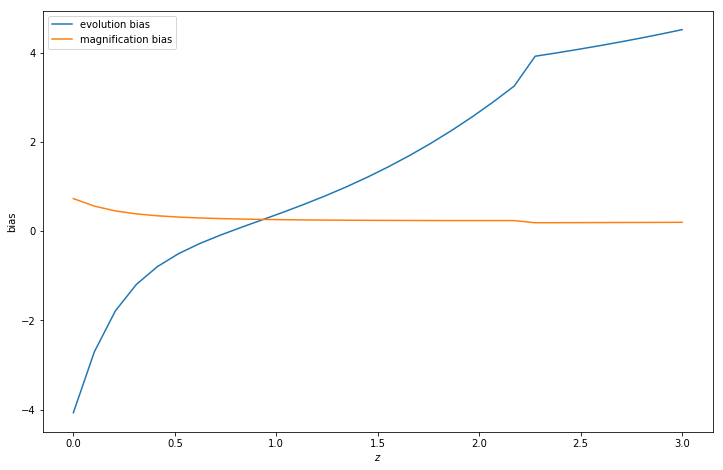

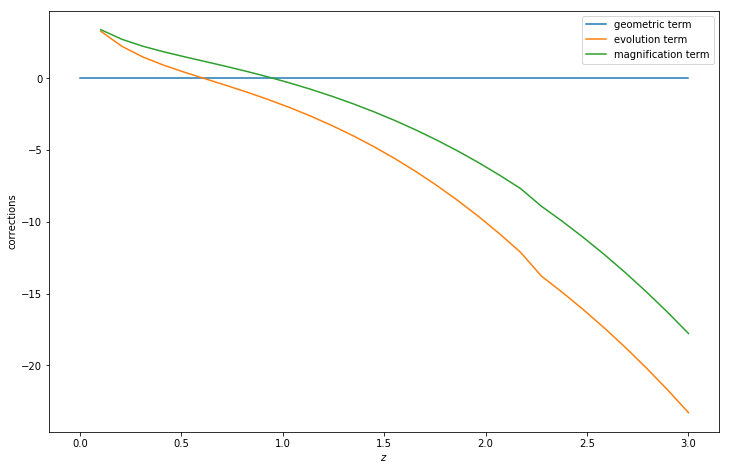

In [12]:
luminosity_modeller = LuminosityFunctionModeller.from_parameters_file(
    quasar_luminosity_function_in_PLE_model,
    magnitude_limit=-21.80,
    file_path="../data/input/PLE_model_fits.txt"
)

relativistic_result = {
    ell: general_relativistic_modification(
        wavenumbers, FIDUCIAL_REDSHIFT, ell,
        geometric_bias=True,
        evolution_bias=luminosity_modeller.evolution_bias, 
        magnification_bias=luminosity_modeller.magnification_bias
    )
    for ell in degrees
}

redshift = np.linspace(3, 0, 30)

plt.figure("Relativistic bias corrections", figsize=(12, 7.75))
plt.plot(redshift, [luminosity_modeller.evolution_bias(z) for z in redshift], label="evolution bias")
plt.plot(redshift, [luminosity_modeller.magnification_bias(z) for z in redshift], label="magnification bias")

plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"bias")

plt.figure("Relativistic corrections", figsize=(12, 7.75))
plt.plot(
    redshift, 
    [general_relativistic_corrections(geometric_bias=True)(z) for z in redshift], 
    label="geometric term"
)
plt.plot(
    redshift,
    [general_relativistic_corrections(geometric_bias=False, evolution_bias=luminosity_modeller.evolution_bias)(z) for z in redshift],
    label="evolution term"
)
plt.plot(
    redshift,
    [general_relativistic_corrections(geometric_bias=False, magnification_bias=luminosity_modeller.magnification_bias)(z) for z in redshift],
    label="magnification term"
)

plt.legend()
plt.xlabel(r"$z$")
plt.ylabel(r"corrections")

In [13]:
FIDUCIAL_NON_GAUSSNIANTY = 50.

non_gaussianity_result = {
    ell: non_gaussianity_multipole_modification(
        wavenumbers, FIDUCIAL_REDSHIFT, ell, 
        FIDUCIAL_NON_GAUSSNIANTY,
        FIDUCIAL_LINEAR_BIAS
    )
    for ell in degrees   
}

Text(0,0.5,'$\\Delta P_\\ell(k) / P_ell^\\mathrm{K}(k)$ [$(h/\\mathrm{Mpc})^3$]')

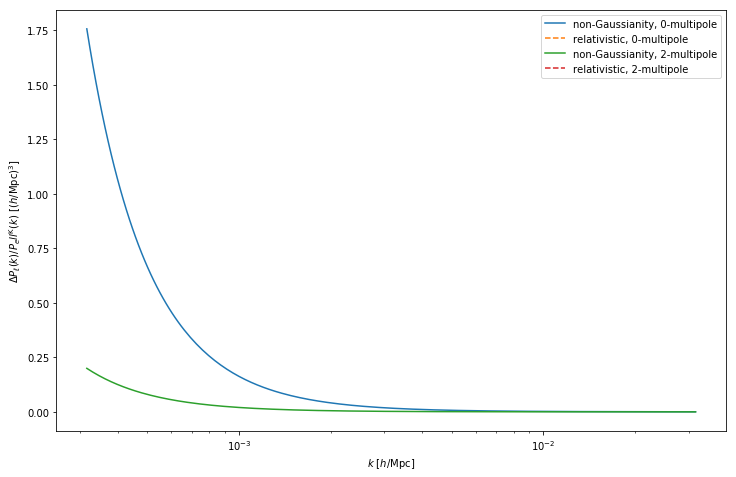

In [14]:
plt.figure("Power spectrum multipole modification", figsize=(12, 7.75))

for ell in degrees:
    plt.semilogx(
        wavenumbers, non_gaussianity_result[ell]/kaiser_result[ell],
        ls='-',
        label="non-Gaussianity, {}-multipole".format(ell)
    )
    plt.semilogx(
        wavenumbers, relativistic_result[ell]/kaiser_result[ell],
        ls='--', 
        label="relativistic, {}-multipole".format(ell)
    )

plt.legend()
plt.xlabel(r"$k$ [$h$/Mpc]")
plt.ylabel(r"$\Delta P_\ell(k) / P_ell^\mathrm{K}(k)$ [$(h/\mathrm{Mpc})^3$]")

In [15]:
for ell in degrees:
    pprint(relativistic_result[ell][0:10])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
